<a href="https://colab.research.google.com/github/TRoYals/My_Algo_Lib/blob/main/bertopic%E6%97%B6%E9%97%B4%E5%8F%98%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 写在前面



### 准备工作

In [ ]:
!pip install seaborn

In [ ]:
!pip install umap-learn -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
     |████████████████████████████████| 86 kB 166 kB/s 
     |████████████████████████████████| 1.1 MB 378 kB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=ceda2406ae2d4abc603c906ffa2ac092bdb96001fba8f2db3efe2288c2fdd3ba
  Stored in directory: /root/.cache/pip/wheels/7e/75/79/307c91d82c4fabf82f921c5b5bf19e24e3334c7f62e1b41c7f
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=b12b5f0c193cad916519773b8215f00597f891b4089dc572a41c57ac72dbe99a
  Stored in directory: /root/.cache/pip/wheels/54/a7/fa/0f1da62c2501194d15332f612d3197c0109df7bb35cf0f389d
Successfully built umap-learn pynndescent


In [ ]:
!pip install hdbscan
!pip install sentence_transformers

     |████████████████████████████████| 6.4 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311952 sha256=aaf1de36e90a2558b8fde06e040eaf5b7c9972e1abddb7ee7a55dcaa343eabb8
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan
     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 3.4 MB 11.0 MB/s 
     |████████████████████████████████| 6.8 MB 23.9 MB/s 
     |████████████████████████████████| 1.2 MB 44.6 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 3.3 MB 52.0 MB/s 
     |████████████████████████████████| 895 kB 58.6 MB/s 
     |████████████████████████████████| 596 kB 64.3 MB/s 
  Created wheel for sentence-transformers: filename=sente

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
import umap.umap_ as umap
import jieba
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [ ]:
import os
import re
import torch

#### 预处理


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data_path = '/content/drive/MyDrive/data/lda-data/output/'

In [ ]:
data_path = '/content/drive/MyDrive/data/'

#### 文件预处理（可跳过）

In [ ]:
cndata = pd.read_csv(os.path.join(data_path,'df_japan.csv'),header=None,encoding='gbk',names=['year','0','1','2','txt'])

In [ ]:
jpdata = pd.read_csv(os.path.join(data_path,'yomiuri_detail.csv'),header=None,encoding='utf-8',names=['0','year','1','txt','2'])

In [ ]:
cndata.head()

In [ ]:
jpdata.head()

In [ ]:
cndata1 = pd.DataFrame(cndata, columns =['txt','year'])

In [ ]:
cndata1.info()

In [ ]:
jpdata1 = pd.DataFrame(jpdata, columns =['txt','year'])

In [ ]:
jpdata1.info()

In [ ]:
data = pd.concat([cndata1,jpdata1])

In [ ]:
data.info()

In [ ]:
data = data.dropna()

In [ ]:
#简单打乱
from sklearn.utils import shuffle
data = shuffle(data)


In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
#data = pd.read_csv(os.path.join(data_path,'kmeans-output.csv'),header=None,names=['txt','1','2'])
#data=data.drop(0).reset_index(drop=True)
#data.dropna(inplace=True)

先处理10w条数据看看

In [ ]:
#data = data.head(100000)

### 提取主题词


In [ ]:
data = data.dropna()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458202 entries, 0 to 458201
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txt     458202 non-null  object
 1   year    458202 non-null  object
dtypes: object(2)
memory usage: 10.5+ MB


长句切割（因为数据集足够大，不需要再做文本分片）

In [ ]:
#后续还可以改进,先不管了
def split_text(text, max_len = 700, split_pat=r'([，。]”?)'):
  if len(text) <= max_len:
    text = ''.join(text.split())
    return text
  text = text[0:max_len] 
  text = ''.join(text.split())
  return text

中日文的不同分词处理




In [ ]:
!pip install mecab-python3==0.996.5
!pip install langid

     |████████████████████████████████| 17.1 MB 6.1 MB/s 
     |████████████████████████████████| 1.9 MB 8.1 MB/s 
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941188 sha256=a8c1957a73552d923eae125bf585f1d25b1c3d0bb4bb31e986063e9854d952be
  Stored in directory: /root/.cache/pip/wheels/2b/bb/7f/11e4db39477278161e882eadc46fb558949a28b13470fc74b8
Successfully built langid


In [ ]:
import joblib
from sklearn.feature_extraction.text import CountVectorizer
import jieba
import langid
import MeCab

In [ ]:
# 加入停词
def stopwordslist(name):
  filepath = "/content/drive/MyDrive/data/lda-data/stopwords/"
  stopwords = [line.strip() for line in open(os.path.join(filepath,name), 'r').readlines()]
  return stopwords

In [ ]:
stop_words_z = stopwordslist("stopwords.txt")
stop_punc = stopwordslist("stopwords-punc.txt")
stop_words_j = stopwordslist("stopwords-char.txt")

In [ ]:
# 细化分词，先识别中文日文，然后调用mecab处理日文，用jieba处理中文。
mecab_tagger = MeCab.Tagger("-Ochasen")
def tokenize_zh(text):
    result = langid.classify(text)[0]
    words=[]
    pieces=[]
    if result=='zh':
      re_word = jieba.lcut(text)
      # 加入n-gram
      re_word2 = [word for word in re_word if word not in (stop_words_z and stop_punc)]
      words.extend(re_word2)
    else:
      x = mecab_tagger.parse(text)
      if x:# 排除结果为none返回空值的情况
        for i in x.splitlines()[:-1]: #结尾的"EOS"顺手去掉
          i = i.split()
          if i[-1].split('-')[0] not in ['助詞','記号']:
            if i[0] not in (stop_words_j and stop_punc): 
              pieces.append(i[0])
      words.extend(pieces)
    sentence = ' '.join(words)
    return sentence

In [ ]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458202 entries, 0 to 458201
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   txt          458202 non-null  object
 1   year         458202 non-null  object
 2   text_length  458202 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.0+ MB


In [ ]:
for i in range(5000):
  try:
    a = tokenize_zh(data['txt'][i])
  except:
    print(i)
  


Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.016 seconds.
Prefix dict has been built successfully.


In [ ]:
data['txt_seg'] = data['txt'].apply(lambda x :tokenize_zh(x))

10w条数据用时12min
48w条数据预估用时50min

In [ ]:
data.head()

,txt,year,text_length,txt_seg
0,——记横沽村中共支部领导的售棉储棉运动毛凤恩单志友编者按：中共河北丰南县横沽村支部是丰南县较...,1951.06.20,697,记横沽村 中共 支部 领导 的 售 棉储棉 运动 毛凤恩 单志友 编者按 中共 河北 丰南县...
1,◆迫られる「価値観の選択」東京会議は「新世界秩序の構築と日本の責務」をテーマにことしのプロジ...,1991.07.30,662,迫ら れる 価値 観 選択 東京 会議 新 世界 秩序 構築 日本 責務 テーマ ことし プ...
2,◆独自の輸入ルートも無許可で散弾を販売したとして１６日、ＮＰＯ法人「県クレー射撃協会」会長、...,2006.02.17,693,独自 輸入 ルート 無 許可 散弾 販売 し た 日 ＮＰＯ 法人 県 クレー 射撃 協会 ...
3,韩健和普拉卡什获男子单打决赛权据新华社东京1月20日电中国选手韩健和印度选手普拉卡什，今天在...,1983.01.22,365,韩健 和 普拉卡什 获 男子单打 决赛权 据 新华社 东京 月 20 日电 中国 选手 韩健...
4,本报讯记者罗雪村报道：4月25日上午，曾经亲历60年前冀中“五一反扫荡”的600余位老战士在...,2002.04.27,366,本报讯 记者 罗雪村 报道 月 25 日 上午 曾经 亲历 60 年前 冀中 五一 反 扫荡...


In [ ]:
data.to_csv(data_path +'jpcndata2.csv',index=0) 

In [ ]:
#data = pd.read_csv(os.path.join(data_path,'data.csv'),header=0)

In [ ]:
data.head()

,txt,year,text_length,txt_seg
0,——记横沽村中共支部领导的售棉储棉运动毛凤恩单志友编者按：中共河北丰南县横沽村支部是丰南县较...,1951.06.20,697,记横沽村 中共 支部 领导 的 售 棉储棉 运动 毛凤恩 单志友 编者按 中共 河北 丰南县...
1,◆迫られる「価値観の選択」東京会議は「新世界秩序の構築と日本の責務」をテーマにことしのプロジ...,1991.07.30,662,迫ら れる 価値 観 選択 東京 会議 新 世界 秩序 構築 日本 責務 テーマ ことし プ...
2,◆独自の輸入ルートも無許可で散弾を販売したとして１６日、ＮＰＯ法人「県クレー射撃協会」会長、...,2006.02.17,693,独自 輸入 ルート 無 許可 散弾 販売 し た 日 ＮＰＯ 法人 県 クレー 射撃 協会 ...
3,韩健和普拉卡什获男子单打决赛权据新华社东京1月20日电中国选手韩健和印度选手普拉卡什，今天在...,1983.01.22,365,韩健 和 普拉卡什 获 男子单打 决赛权 据 新华社 东京 月 20 日电 中国 选手 韩健...
4,本报讯记者罗雪村报道：4月25日上午，曾经亲历60年前冀中“五一反扫荡”的600余位老战士在...,2002.04.27,366,本报讯 记者 罗雪村 报道 月 25 日 上午 曾经 亲历 60 年前 冀中 五一 反 扫荡...


### 创建word embedding

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2',device='cuda')

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embeddings = model.encode(data['txt'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/14319 [00:00<?, ?it/s]

In [ ]:
embeddings.shape

(458202, 384)

### 句嵌入降维处理

In [ ]:

%%time
umap_embeddings = umap.UMAP(
      n_neighbors=25,
      n_components=10,
      min_dist=0.00,
      metric='cosine',
      random_state=2020).fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 39min 12s, sys: 3min 46s, total: 42min 58s
Wall time: 24min 58s


#### HDBSCAN进行文档聚类

In [ ]:

%%time
cluster = hdbscan.HDBSCAN(
      min_cluster_size=100,
      metric='euclidean',
      cluster_selection_method='eom', 
      prediction_data=True).fit(umap_embeddings)

CPU times: user 1min 34s, sys: 3.16 s, total: 1min 37s
Wall time: 2min 23s


In [ ]:
%%time
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_





CPU times: user 46min 15s, sys: 5min 10s, total: 51min 25s
Wall time: 13min 39s


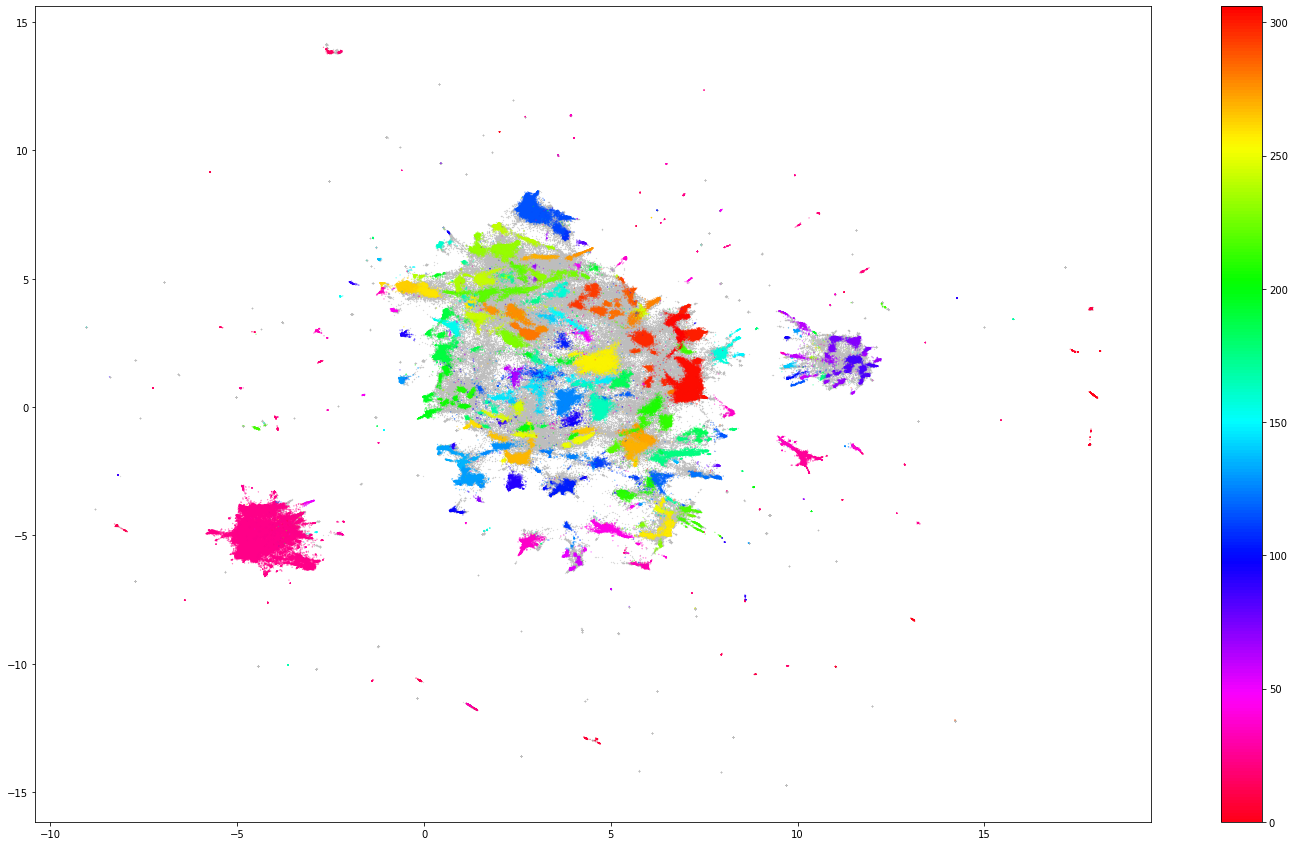

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(25, 15))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
# plt.savefig("result1.png", dpi = 300)


#### 主题建模展示


In [ ]:
docs_df = pd.DataFrame(data['txt_seg'].tolist(), columns=["Doc"])

In [ ]:
docs_df['Topic'] = cluster.labels_

In [ ]:
docs_df['Doc_ID'] = range(len(docs_df))

In [ ]:
docs_df['year'] = data['year']

In [ ]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
docs_df

,Doc,Topic,Doc_ID,year
0,记横沽村 中共 支部 领导 的 售 棉储棉 运动 毛凤恩 单志友 编者按 中共 河北 丰南县...,-1,0,1951.06.20
1,迫ら れる 価値 観 選択 東京 会議 新 世界 秩序 構築 日本 責務 テーマ ことし プ...,-1,1,1991.07.30
2,独自 輸入 ルート 無 許可 散弾 販売 し た 日 ＮＰＯ 法人 県 クレー 射撃 協会 ...,-1,2,2006.02.17
3,韩健 和 普拉卡什 获 男子单打 决赛权 据 新华社 东京 月 20 日电 中国 选手 韩健...,23,3,1983.01.22
4,本报讯 记者 罗雪村 报道 月 25 日 上午 曾经 亲历 60 年前 冀中 五一 反 扫荡...,-1,4,2002.04.27
...,...,...,...,...
458197,北京 日 荒井 利明 過去 一 年間 その 動向 ほとんど 伝え られ なかっ た 中国 最...,-1,458197,1992.02.06
458198,日本 社会党人 将 掀起 恢复 日中 邦交 运动 在 回答 记者 提出 的 问题 时 浅沼 ...,-1,458198,1957.04.13
458199,新华社 香港 月 25 日电 香港 伤残 青年 协会 为 响应 1985 年 国际 青年 年...,255,458199,1985.07.26
458200,高校 野球 予選 順延 夏休み 週末 行楽 ノロノロ 台風 直撃 台風 九 号 影響 西日本...,23,458200,1997.07.26


In [ ]:
docs_per_topic

,Topic,Doc
0,-1,记横沽村 中共 支部 领导 的 售 棉储棉 运动 毛凤恩 单志友 编者按 中共 河北 丰南县...
1,0,米ドル 銀行 間 直 物 午後 時 現在 前日 高値 安値 出来高 日 億 万 ドル 対 顧...
2,1,単位 円 米ドル 銀行 間 直 物 午後 時 現在 前 営業 日 比 高値 安値 前 営業 ...
3,2,単位 円 米ドル 銀行 間 直 物 午後 時 現在 前 営業 日 比 高値 安値 前 営業 ...
4,3,単位 円 米ドル 銀行 間 直 物 午後 時 現在 前 営業 日 比 高値 安値 前 営業 ...
...,...,...
303,302,関西 写真 文化 活性 化 目指す 大阪 写真 月間 実行 委員 会 山本 博之 代表 写真...
304,303,日本人 心 ふるさと そして 古代 史 ブーム 震源 地 ある 奈良 飛鳥 その 五 十 年...
305,304,试谈 影片 归心似箭 的 艺术 成就 林洪桐 春节 中 看 了 李克异 编剧 李俊 导演 八...
306,305,本报讯 为 全面 宣传 和 贯彻 国务院 颁布 的 全民 健身 计划 纲要 由 国家体委 和...


In [ ]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):    
  words = count.get_feature_names()    
  labels = list(docs_per_topic.Topic)    
  tf_idf_transposed = tf_idf.T    
  indices = tf_idf_transposed.argsort()[:, -n:]    
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}    
  return top_n_words

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):    
  words = count.get_feature_names()    
  labels = list(docs_per_topic.Topic)    
  tf_idf_transposed = tf_idf.T    
  indices = tf_idf_transposed.argsort()[:, -n:]    
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}    
  return top_n_words

def extract_topic_sizes(df):    
  topic_sizes = (df.groupby(['Topic'])                     
  .Doc                     
  .count()                     
  .reset_index()                     
  .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')                     
  .sort_values("Size", ascending=False))
  return topic_sizes

In [ ]:

def c_tf_idf(documents, m, ngram_range=(1, 1),stopwords = stop_words_z+stop_words_j+stop_punc):
  my_stopwords =  stopwords
  count = CountVectorizer(
      ngram_range=ngram_range,                             
      stop_words= my_stopwords).fit(documents)
  t = count.transform(documents).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)
  return tf_idf, count

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data))   

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lastweek', 'news', 'u3000', 'ｔｏｐｎｅｗｓ'] not in stop_words.
  % sorted(inconsistent)


In [ ]:
len(docs_per_topic.Doc.tolist())

308

In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)   

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def onlyname(list):
  a = ''
  for i in list:
    a = a + ' ' + str(i[0])
  return a

In [ ]:
def topicoverview(list,num = 20):
  topicoverview = []
  for i in list[0:num]:
    topicoverview.append(i[0])
  return topicoverview

In [ ]:
output = pd.DataFrame(columns=['topicid','topic','topicdetail'],index=range(len(top_n_words)))

In [ ]:
for i in range(len(top_n_words) - 1):
  output['topicid'][i] = i
  output['topicdetail'][i] = top_n_words[i]
  output['topic'][i] = topicoverview(top_n_words[i])

In [ ]:
output.to_csv(data_path +'TopicResult1.csv',index=0) 

In [ ]:
output

,topicid,topic,topicdetail
0,0,"[ドル, 銀行, 米ドル, ペソ, デンマーククローネ, ノルウェークローネ, コーポレート...","[(ドル, 0.13822708198981554), (銀行, 0.12850216224..."
1,1,"[相場, ドル, 銀行, 電信, 売り, ルピア, 参考, ペソ, 米ドル, 営業, マレー...","[(相場, 0.22691148239853093), (ドル, 0.17221426978..."
2,2,"[相場, ドル, 銀行, 電信, 売り, ルピア, 参考, ペソ, 米ドル, 営業, ブラジ...","[(相場, 0.21997661916657751), (ドル, 0.16695106143..."
3,3,"[相場, ドル, 銀行, 電信, 売り, ルピア, 参考, ペソ, 米ドル, 営業, ブラジ...","[(相場, 0.2246942637295575), (ドル, 0.170531513627..."
4,4,"[ドル, 銀行, 相場, ルピア, 参考, ペソ, 米ドル, 営業, マレーシアリンギット,...","[(ドル, 0.17329818859889787), (銀行, 0.17211712312..."
...,...,...,...
303,303,"[出土, 時代, 展示, 作品, 遺跡, 美術館, 博物館, 古墳, 世紀, 美術, 奈良,...","[(出土, 0.018374044290490936), (時代, 0.0178985229..."
304,304,"[映画, 監督, 电影, 上映, 影片, 作品, 电影节, 主演, 撮影, 公開, 俳優, ...","[(映画, 0.09108392593673895), (監督, 0.04276414237..."
305,305,"[公演, サーカス, 披露, 踊り, ポップ, 大道芸, ブランコ, 雑技, 空中, テント...","[(公演, 0.07572634477126217), (サーカス, 0.063019948..."
306,306,"[演出, 公演, 上演, バレエ, 舞台, 劇場, 歌舞伎, 劇団, 观众, 演员, 戏剧,...","[(演出, 0.04597981713921421), (公演, 0.03243885177..."


#### 时间变化主题图

In [ ]:
OverTime = pd.DataFrame(columns=range(len(top_n_words)),index=range(1940,2021))

NameError: ignored

In [ ]:
for col in OverTime.columns:
  OverTime[col].values[:] = 0

NameError: ignored

In [ ]:
for i in range(len(docs_df)):
  year = str(docs_df['year'][i])[0:4]
  topic = docs_df['Topic'][i]
  if topic != -1:
    OverTime[topic][int(year)] = 1 + OverTime[topic][int(year)]

In [ ]:
OverTime

In [ ]:
OverTime.to_csv(data_path +'Overtime1.csv',index=0) 

NameError: ignored

In [ ]:
##读表
OverTime = pd.read_csv(data_path +'Overtime1.csv')

In [ ]:
output = pd.read_csv(data_path+'TopicResult1.csv')

In [ ]:
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"


--2022-01-23 01:07:23--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  5.53MB/s    in 1.7s    

2022-01-23 01:07:25 (5.53 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [ ]:
#绘制主题数量变化图
def topicovertime(topicnumber = [3,5,6],timetable = OverTime,output = output,font= zhfont):
  dates = range(1940,2021)
  overview = []
  plt.figure(figsize=(15, 10))
  for topicid in topicnumber:
    overview.append(str(topicid)+'_'.join(eval(output['topic'][topicid])[0:5]))
  data = pd.DataFrame(OverTime.values[:,topicnumber], dates, columns=overview)
  data = data.rolling(7).mean()
  ax = sns.lineplot(data=data, palette="tab10", linewidth=2.5,legend=False)
  plt.xlabel(u'年份', fontproperties=zhfont)
  plt.ylabel(u'数量', fontproperties=zhfont)
  plt.legend(overview, prop=zhfont)
  plt.title('Raw', fontproperties=zhfont,fontsize=30)
  plt.savefig("1.png")

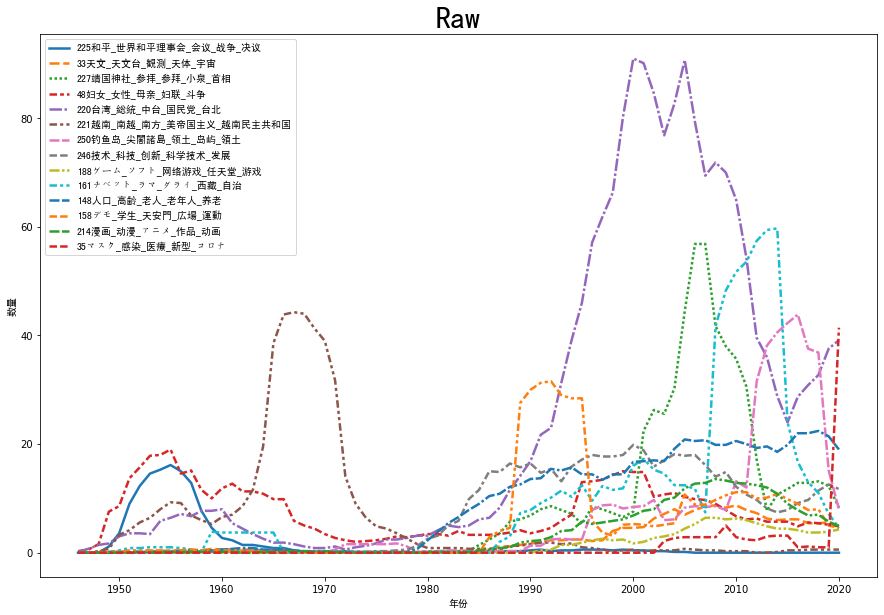

In [ ]:
topicovertime([225,33,227,48,220,221,250,246,188,161,148,158,214,35])

In [ ]:
from sklearn import preprocessing


In [ ]:
def Nortopicovertime(topicnumber = [3,5,6],timetable = OverTime,output = output,font= zhfont):
  dates = range(1940,2021)
  overview = []
  plt.figure(figsize=(25, 15))
  for topicid in topicnumber:
    overview.append(str(topicid)+'_'.join(eval(output['topic'][topicid])[0:5]))
  data = pd.DataFrame(preprocessing.scale(OverTime.values[:,topicnumber]), dates, columns=overview)
  data = data.rolling(7).mean()
  ax = sns.lineplot(data=data, palette="tab10", linewidth=2.5,legend=False)
  plt.xlabel(u'年份', fontproperties=zhfont)
  plt.ylabel(u'数量', fontproperties=zhfont)
  plt.legend(overview, prop=zhfont)
  plt.title('Normalized', fontproperties=zhfont,fontsize=30)
  plt.savefig("2.png")

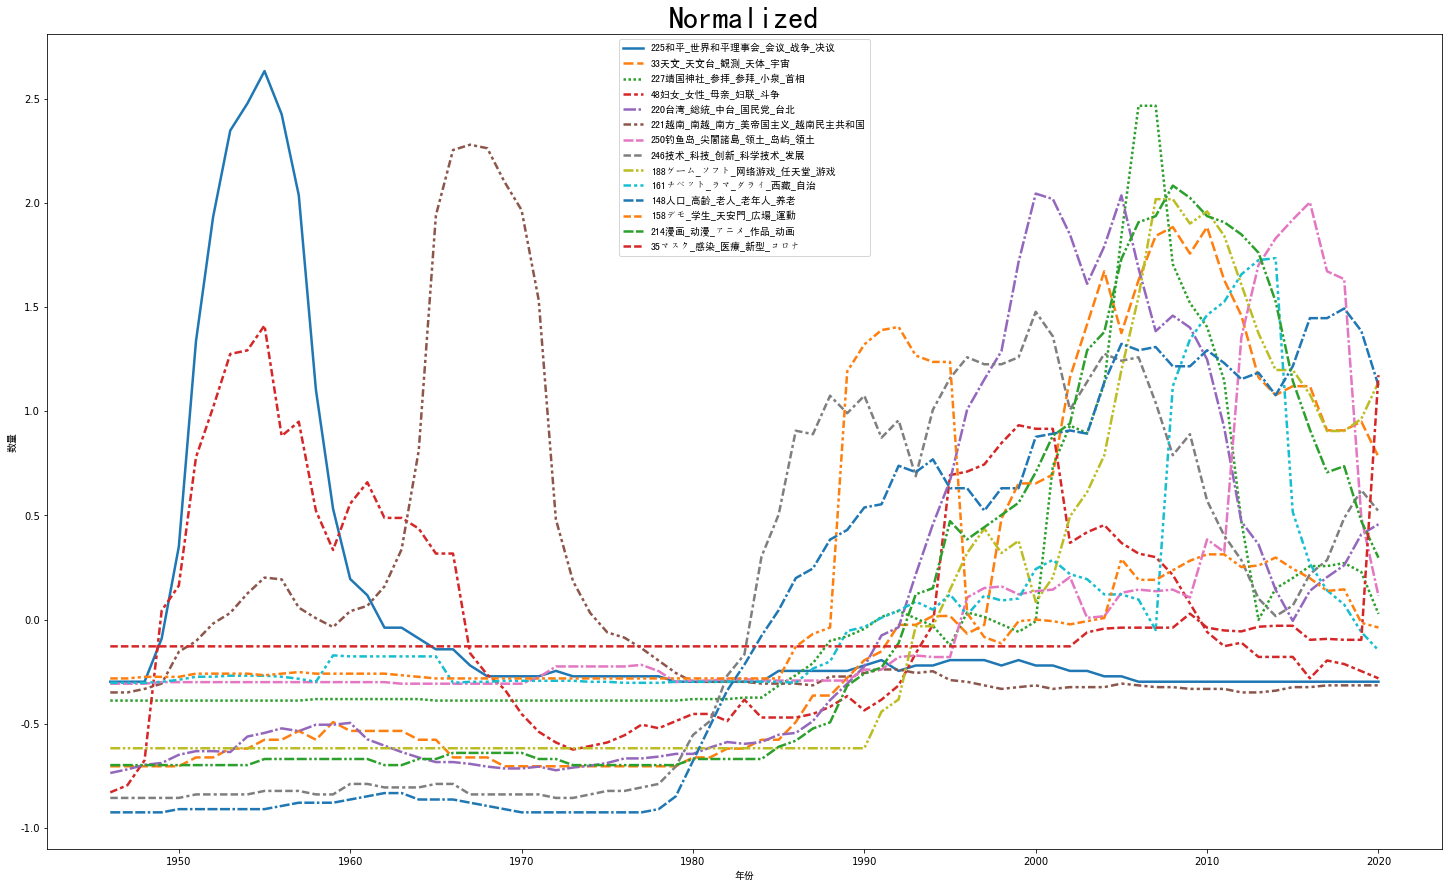

In [ ]:
Nortopicovertime([225,33,227,48,220,221,250,246,188,161,148,158,214,35])

2022.01.19
1. 基于时间标签，调用主题模型对中日文数据进行主题分类。
2. 数据总量48w条，其中中文数据13w条，日文数据35w条。
3. 中文数据的时间跨度为1940年至2020年，日文数据的时间跨度为1986年至2020年，二者时间跨度区别较大，在模型中根据要求一同展示。
4. 所有的主题列表保存在TopicResult4.csv,主题数量-年份数图 保存至OverTime.csv，可根据项目的需求绘制相关图片。
5. 聚合出来的主题数量为307个，需要进一步的人工筛选。
6. 部分主题数量-年份图参考示例。
7. 前一版聚合出来的主题在这一版中均得到了较好的继承。


注意：
1. 因为数据量较大，仅对文章进行了简单的分词处理，并未进行相关的新词挖掘工作。
2. 因为日文数据集的偏差，部分意义不明的数据集导致主题中出现了部分冗余的部分。